# Neutron Star Class SPH Code

Source:

https://philip-mocz.medium.com/create-your-own-smoothed-particle-hydrodynamics-simulation-with-python-76e1cec505f1

https://github.com/zaman13/Modeling-of-Neutron-Stars/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py

#from ipynb.fs.full.Neutron_Star_SPH_sph import W, gradW, getPairwiseSeparations, getDensity
#from ipynb.fs.full.Neutron_Star_SPH_eos import EOS, initial_n, rho_NS

rho_s = 1665.3 #  Central density (density at r = 0)
hc = 197.327           # Conversion factor in MeV fm (hut * c) # hbar * c =1.9733×10−11 MeV cm...
G = hc * 6.67259e-45   # Gravitational constant
Ms = 1.1157467e60      # Mass of the sun in kg
mn = 938.926           # Mass of neutron in MeV c^-2

In [2]:
def W(x,y,z,h):
    """ Defined Gausssian Smoothing kernel (3D).
    (x is a vector/matrix of x positions, y is a vector/matrix of y positions. 
    z = vector/matrix of z positions, h = smoothing length, w = evaluated smoothing function."""
    r = np.sqrt(x**2 + y**2 + z**2) 
    return (1.0 / (h*np.sqrt(np.pi)))**3 * np.exp( -r**2 / h**2) # return w
    
def gradW(x,y,z,h):
    """ Gradient of smoothing kernel. We can reconstruct the density at any location using the smoothing kernels.
    (x is a vector/matrix of x positions, y is a vector/matrix of y positions, z is a vector/matrix of z positions, h is the smoothing length, wx, wy, wz  is the evaluated gradient)"""
    r = np.sqrt(x**2 + y**2 + z**2)  
    n = -2 * np.exp( -r**2 / h**2) / h**5 / (np.pi)**(3/2)
    return n*x, n*y, n*z  # (gradient in the x, y, and z directions)
    
def getPairwiseSeparations(ri, rj):
    """ Just finds Cartesian Pairwise Separations between 2 points. 
    ri is an M x 3 matrix of positions, 
    rj    is an N x 3 matrix of positions 
    dx, dy, dz   are M x N matrices of separations. """
    M = ri.shape[0]
    N = rj.shape[0]
    rix = ri[:,0].reshape((M,1)) # positions ri = (x,y,z)
    riy = ri[:,1].reshape((M,1))
    riz = ri[:,2].reshape((M,1))
    rjx = rj[:,0].reshape((N,1)) # other set of points positions rj = (x,y,z)
    rjy = rj[:,1].reshape((N,1))
    rjz = rj[:,2].reshape((N,1))
    return rix - rjx.T , riy - rjy.T, riz - rjz.T # (dx, dy, dz) # return matrices that store all pairwise particle separations: r_i - r_j

def getDensity(r, pos, m, h ):
    """ Reconstruct the density at any location based on the sph points.
            r     is an M x 3 matrix of sampling locations
            pos   is an N x 3 matrix of SPH particle positions
          
          dx, dy, dz are all M x N matrices. (Seperations). 
          - Sum over all particle interactions with the points to get the density at the locations in r.
          
          m = particle mass, h = smoothing length """
    
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations( r, pos );
    rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1))
    return rho

In [3]:
def rho_NS(p): 
    """ density from pressure NS, source: https://github.com/zaman13/Modeling-of-Neutron-Stars/ """
    n = (p*rho_s/363.44)**(1./2.54)
    return (236. * n**2.54 + n *mn)/rho_s 

def dp_dr_NS(r,m,p, Classical = False): 
    """ pressure dependence on radius NS, source: https://github.com/zaman13/Modeling-of-Neutron-Stars/ """
    if Classical:                              # classical model
        y = -m*rho_NS(p)/(r**2 + 1e-20)
    else:                                      # relativistic model
        rh = rho_NS(p)                            
        y = -(p+rh)*(p*r**3 + m)/(r**2 - 2*m*r + 1e-20)
    return y

def dm_dr_NS(r,m,p):
    """ Mass dependence on radius (dm/dr)."""
    return rho_NS(p)*r**2

def initial_n(eos): # # Function for determining initial value of n(r=0)
    n = 1
    err = 1
    tol = 1e-15
    count = 0
    rho_s = eos.rho_s
    # Newton-Raphson method
    while err > tol : 
        count += 1
        fn = n*mn + 236*n**(2.54) - rho_s
        dfn = mn + 236*2.54*n**(1.54)
        temp = n - fn/dfn
        err = np.abs(n-temp)
        n = temp
    print("Newton-Raphson Converged after ", count, "iterations")
    return n

class EOS: 
    def __init__(self, name = 'standard', P= None, dp_dr= None, notes = "None"):
        """ Initialize an EOS Object to use multiple times.
        If the name is regocnized, the EOS will already have all of it's properties built in.  If not, you can specify the properties. 
        """
        self.name = name.lower()
        if self.name == 'standard':
            
            rho_s = 1665.3 #  Central density (density at r = 0)
            self.rho_s = rho_s
            self.M0 = (4*3.14159265*(G**3)*rho_s)**(-0.5)
            self.R0 =  G*self.M0
            self.rho = lambda x : rho_NS(x)
            self.dp_dr = lambda r,m,p, flag: dp_dr_NS(r,m,p, flag)
            self.dm_dr = lambda r, m, p: dm_dr_NS(r,m,p)
            self.notes = 'Standard EOS.'
            h = 0.1 # smoothing length
            k = 0.1 # equation of state constant
            n = 1 # polytropic index
            nu = 1 # damping
            self.constants = {"h":(h, "smoothing length (h)"),"k": (k,"equation of state constant (k)"),"n" :(n,'polytropic index (n)'), 'rho_s': (rho_s, "Central density"), 'nu': (nu, "<insert description> (nu)")}
            self.lmbda = lambda M,R : 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  #is external force constant, ~ 2.01
        
        else:
            self.P = P
            self.dp_dr = dp_dr
            self.notes = notes
            
    def __str__(self):
        return "EOS Object. Type: " + self.name + "\nNotes: " + self.notes + "\n-------\n"+ str(self.constants) +  "\n\n For more information, see the imported EOS file."
    
    def P_eos(self, rho): 
        func = self.P
        return func(rho)

In [4]:
def EulerSolver(r,m,p,h,eos, flag = False):
    """ Euler Solver which iterates P and mass"""
    y = np.zeros(2)
    dp_dr = eos.dp_dr # extract the relevant dp_dr from the given EOS.
    dm_dr = eos.dm_dr 
    y[0] = m + dm_dr(r,m,p,flag)*h
    y[1] = p + dp_dr(r,m,p,flag)*h
    print(dp_dr(r,m,p,flag))
    return y

def getPressure(star):
    eos = star.eos
    rho = star.rho
    k = eos.constants["k"][0]
    n = eos.constants["n"][0]
    P = k * rho**(1+1/n)
    return P 

def getAcc(star):
    """ Calculate the acceleration on each SPH particle given current positions and velocities.
    
    'pos' contains particle coordinates (N x 3 matrix)
    'vel' contains particle velocities (N x 3 matrix)
    returns 'a' containing accelerations (another N x 3 matrix)
    
    m = particle mass, h = smoothing length, k = equation of state constant, n = polytropic index, lmbda = external force constant, nu = viscosity. 
    
    """ 
    eos = star.eos
    # Fixes: nu can come from the eos. I think h too. 
    nu = star.nu
    m = star.m
    h = star.h
    lmbda = eos.lmbda(star.mass, star.radius)
    
    # Exctract positions and velocities of points from the star
    pos = star.pos 
    vel = star.vel
    
    N = pos.shape[0] # Number of particles
    # I think you already did this and you can just use the star's density....
    rho = star.rho 
    P = getPressure(star) # Get the pressures corresponding to those densities
    dx, dy, dz = getPairwiseSeparations( pos, pos ) # Get pairwise distances
    dWx, dWy, dWz = gradW( dx, dy, dz, h )# Get pairwise gradients
    ax = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWx, 1).reshape((N,1)) # Add x Pressure contribution to accelerations
    ay = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWy, 1).reshape((N,1)) # Add y Pressure contribution to accelerations
    az = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWz, 1).reshape((N,1)) # Add z Pressure contribution to accelerations
    a = np.hstack((ax,ay,az)) # pack together the acceleration components
    
    ##### Extra forces
    a -= lmbda * pos # Add external potential force
    a -= nu * vel # Add viscosity
    return a

In [5]:
class NS:
    def __init__(self, tag, eos, mass = 1, radius = 1, num_points = 300):
        """
        NEUTRON STAR OBJECT
        
        A neutron star has the following attributes: 
            - tag, mass, radius, num_points  (eos?)
            
        A point has the following attributes: 
            - position (N x 3), vel (N x 3), acc (N x 3), density (N x 1), pressure (N x 1).        
        
        Goal: we want to give this star it's overall attributes and calculate the point attributes automatically.
        
        """
        #### INFO 
        self.tag = tag # "Name" of the star, just a string for identification
        self.radius = radius # star radius in km
        self.mass = mass # star mass in solar Masses
        self.eos = eos # equation of state
        self.radius_unit = 1 # if the radius of the star is given in units other than kilometers, you can give it a scale factor here.    
        self.num_points = num_points 
        self.m = mass/num_points # each point has mass m (maybe change later to baryon number)
        
        ################################################################
        ##### INITIALIZE STAR 
        # for each point in the star, initialize random positions and velocities.
        np.random.seed(42) # set the random number generator seed
        self.pos = np.random.randn(self.num_points,3)   # randomly select positions and velocit-ies from initialized seed
        self.vel = np.zeros(self.pos.shape)    # randomly select positions and velocities positions and velocities are N x 3 matrices.
        self.acc = np.zeros(self.pos.shape)  # initially we haven't updated the accelerations of those random points for the star.
        self.rho = None
        self.density = None
        ##### RELAXATION STEP --> RANDOM POINTS RELAX TO MATCH DENSITY
        dt = 0.05
        tEnd = 10
        N = num_points # Number of particles (redefined)
        M = mass # total star mass (Solar Masses) (redefined)
        R = radius # star radius (km) (redefined)
        k = eos.constants["k"][0] # equation of state constant
        n = eos.constants["n"][0] # polytropic index
        h = 0.05 # from previous results, this seems like a good smoothing length.
        self.h = h
        nu = 1 # damping
        self.nu = nu
        lmbda = eos.lmbda(M,R)
        self.rho = getDensity(self.pos, self.pos, self.m, h) 
        
        t = 0      # current time of the simulation
        Nt = int(np.ceil(tEnd/dt)) # number of timesteps
        
        for i in range(Nt): # Star Simulation Time Iteration Main Loop
            self.vel += self.acc * dt/2 # (1/2) kick # adds acceleration
            self.pos += self.vel * dt # particle motion
            self.acc = getAcc(self) # get new Nx3 matrix of accelerations based on new pos,v
            self.vel += self.acc * dt/2 # (1/2) kick 
            t += dt # update time
            if t % dt*100==0: # print every 100 timesteps
                print("Star initialization.  timestep: " , t)
            self.rho = getDensity(self.pos, self.pos, self.m, h) # get updated density for each point based on m, h. 
        
        sd =  "\nSTAR OBJECT. Name: '" + self.tag + "', Mass: " + str(self.mass) + " SMs, "+ "Radius: " + str(self.radius*self.radius_unit) + " km" 
        print("-------success!\n", sd, "\n")
        return None
    
    
    def __str__(self):
        return "\nSTAR OBJECT. Name: '" + self.tag + "', Mass: " + str(self.mass) + " SMs, "+ "Radius: " + str(self.radius*self.radius_unit) + " km" 
    
    def update_motion(self, com_pos_new): 
        """ This function will update the positions of the points for one timestep 
        based on the force acting on the center of gravity of the star. 
        
        The points of one star only recieve center of gravity info and react to each other
        They do not interact directly with the points of the other star.
        
        pos_array, vel_array, acc_array must be arrays with 3 elements (x,y,z) 
        
        """
        self.pos = self.pos[:] + com_pos_new
        return None
    
    def get_position(self):
        """ 
        This function returns the star's position. 
        
        """
        return self.pos
    
    def get_velocity(self):
        """ 
        This function returns the star's velocity. 
        
        """
        return self.vel
    
    def get_mass(self):
        """ 
        This function returns the star's overall mass . 
        
        """
        return self.mass



def plot(stars, x_lim = 50, y_lim = 50,fig_size=(4,5), dpi_ = 300, gridspecs=[3,1], fig=None, ax=None, density_plot = False):
    """ Takes in any number of stas and plots their points. """
    if fig == None: 
        fig = plt.figure(figsize=fig_size, dpi=dpi_)
        grid = plt.GridSpec(gridspecs[0], gridspecs[1], wspace=0.0, hspace=0.3)
    if ax == None:
        ax1 = plt.subplot(grid[0:2,0])
        if density_plot:
            ax2 = plt.subplot(grid[2,0])# for second plot
    else:
        ax1=ax

        
    rr = np.zeros((100,3))
    rlin = np.linspace(0,1,100)
    rr[:,0] =rlin
    plt.sca(ax1)
    plt.cla()
    title = ""
    for i in range(len(stars)):
        star = stars[i]
        pos = star.pos[:]
        rho = star.rho
        cval = np.minimum((rho-3)/3,1).flatten()
        plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
        title = title + str(star)
        
    ax1.set(xlim=(-x_lim, x_lim), ylim=(-y_lim, y_lim))
    ax1.set_aspect('equal', 'box')
    ax1.set_facecolor('black')
    ax1.set_facecolor((.1,.1,.1))

    plt.title(str(title))
    plt.xlabel("km")
    plt.ylabel("km")
    
# # density plot
#     rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
#     if density_plot:
#         plt.sca(ax2)
#         plt.cla()
#         ax2.set(xlim=(0, 1), ylim=(0, 3))
#         ax2.set_aspect(0.1)
#         plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
#         rho_radial = getDensity( rr, pos, m, h )
#         plt.plot(rlin, rho_radial, color='blue')
#         plt.pause(0.001)
    return None



In [6]:
myEOS = EOS('standard') # create an equation of state object

myNS = NS("my Neutron star 1", myEOS,0.5,0.5)
myNS2 = NS("my Neutron star 2", myEOS,2,1) # double the mass and radius of the first star

Star initialization.  timestep:  0.05
Star initialization.  timestep:  0.1
Star initialization.  timestep:  0.2
-------success!
 
STAR OBJECT. Name: 'my Neutron star 1', Mass: 0.5 SMs, Radius: 0.5 km 

Star initialization.  timestep:  0.05
Star initialization.  timestep:  0.1
Star initialization.  timestep:  0.2
-------success!
 
STAR OBJECT. Name: 'my Neutron star 2', Mass: 2 SMs, Radius: 1 km 



# Colliding objects

In [17]:
l=[0]
l.append([rad*10,(x,y,z),col,True])
l.append([rad*10,(2*x,y,z),col,True])
l

[0,
 [6960000000.0, (0, 0, 0), 'yellow', True],
 [6960000000.0, (0, 0, 0), 'yellow', True]]

In [18]:
l[1][1]

(0, 0, 0)

In [23]:
animscene = display(title='stellar motion', x=0,y=0)

mass_list=[0]
mass_list.append(1.989e30) # ibb=1
mass_list.append(5.972e24) # ibb =2

nbbs =len(mass_list)-1
ibb=1
bb_list=[0]
vel_list=[0]

x=0
y=0
z=0
rad = 696.3e6
col = 'yellow'
# {"radius":rad*10, "pos":(x,y,z), "color":col, "make_trail":True}
bb_list.append([rad*10,(x,y,z),col,True])
vx=0
vy=0
vz=0
vel_list.append(np.array([vx,vy,vz]))

x=147.1e9
y=0
z=0
rad=6e6
col='blue'
# {"radius":rad*10, "pos":(x,y,z), "color":col, "make_trail":True}
bb_list.append([rad*10,(x,y,z),col,True])

ang_mom = 149.6e9**2*2*3.14159*mass_list[2]/(365.25*24*360)
vx=0
vy=ang_mom/(147.1e9*mass_list[2])
vz=0
vel_list.append(np.array([vx,vy,vz]))

force_list=[0]
ibb=1
while ibb<= nbbs:
    force_list.append(np.array([0,0,0]))
    ibb = ibb+1
    
t=0
dt=100
G=6.67e-11

kinetic=0.0
ibb=1
while ibb<= nbbs:
    kinetic=kinetic+0.5*mass_list[ibb]*(np.linalg.norm(vel_list[ibb]))**2
    ibb=ibb+1
    
potential = 0.0
ibb=1
while ibb<=nbbs-1:
    ibb2=ibb+1
    while ibb2<=nbbs:
        r=get_r(bb_list[ibb][1], bb_list[ibb2][1])
        potential = potential-G*mass_list[ibb]*mass_list[ibb2]/np.linalg.norm(get_r(bb_list[ibb][1],bb_list[ibb2][1]))
        ibb2=ibb2+1
    ibb=ibb+1
    
    
angmom = np.array([0,0,0])
ibb=1
while ibb<=nbbs:
    angmom=angmom+np.cross(bb_list[ibb][1], mass_list[ibb]*vel_list[ibb])
    ibb=ibb+1
    
print('total energy=', kinetic+potential)
print('total angmom=', angmom)


TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [30]:
bb_list[1][1]

(0, 0, 0)

In [7]:
mass_obj1 = myNS.get_mass() *10**3
mass_obj2 = myNS2.get_mass() *10**3
G = 20 #6.673*(10**-11)

pos_obj1 = np.array([0,0,0])
pos_obj2 = np.array([1, 5, 0])

v_obj1 = [0,0,0]
v_obj2 = [0,0,0]

def grav_force(mass_1, mass_2, r, vec):
    return -1*vec*(G*mass_1*mass_2)/(r**2)

def get_r(pos1, pos2):
    if len(pos1)==3 and len(pos2)==3:
        d = [pos1[0]-pos2[0], pos1[1]-pos2[1], pos1[2]-pos2[2]]
        dist = np.sqrt(d[0]**2+d[1]**2+d[2]**2)
        direc = np.array([d[0] / dist, d[1] / dist, d[2] / dist])
    #elif len(pos1)==2 and len(pos2)==2:
    #    d = [pos1[0]-pos2[0], pos1[1]-pos2[1]]
    #    norm = np.sqrt(d[0]**2+d[1]**2)
    #    direc = np.array([d[0] / norm, d[1] / norm])
    else:
        print("location error")
        norm = 0
        direc = np.array(0,0,0)
    return dist, direc

def AddPoint(plot, x, y, color, lbl):
    plot.scatter(x, y, c=color, label=lbl)
    plot.clf()
    plot.show()

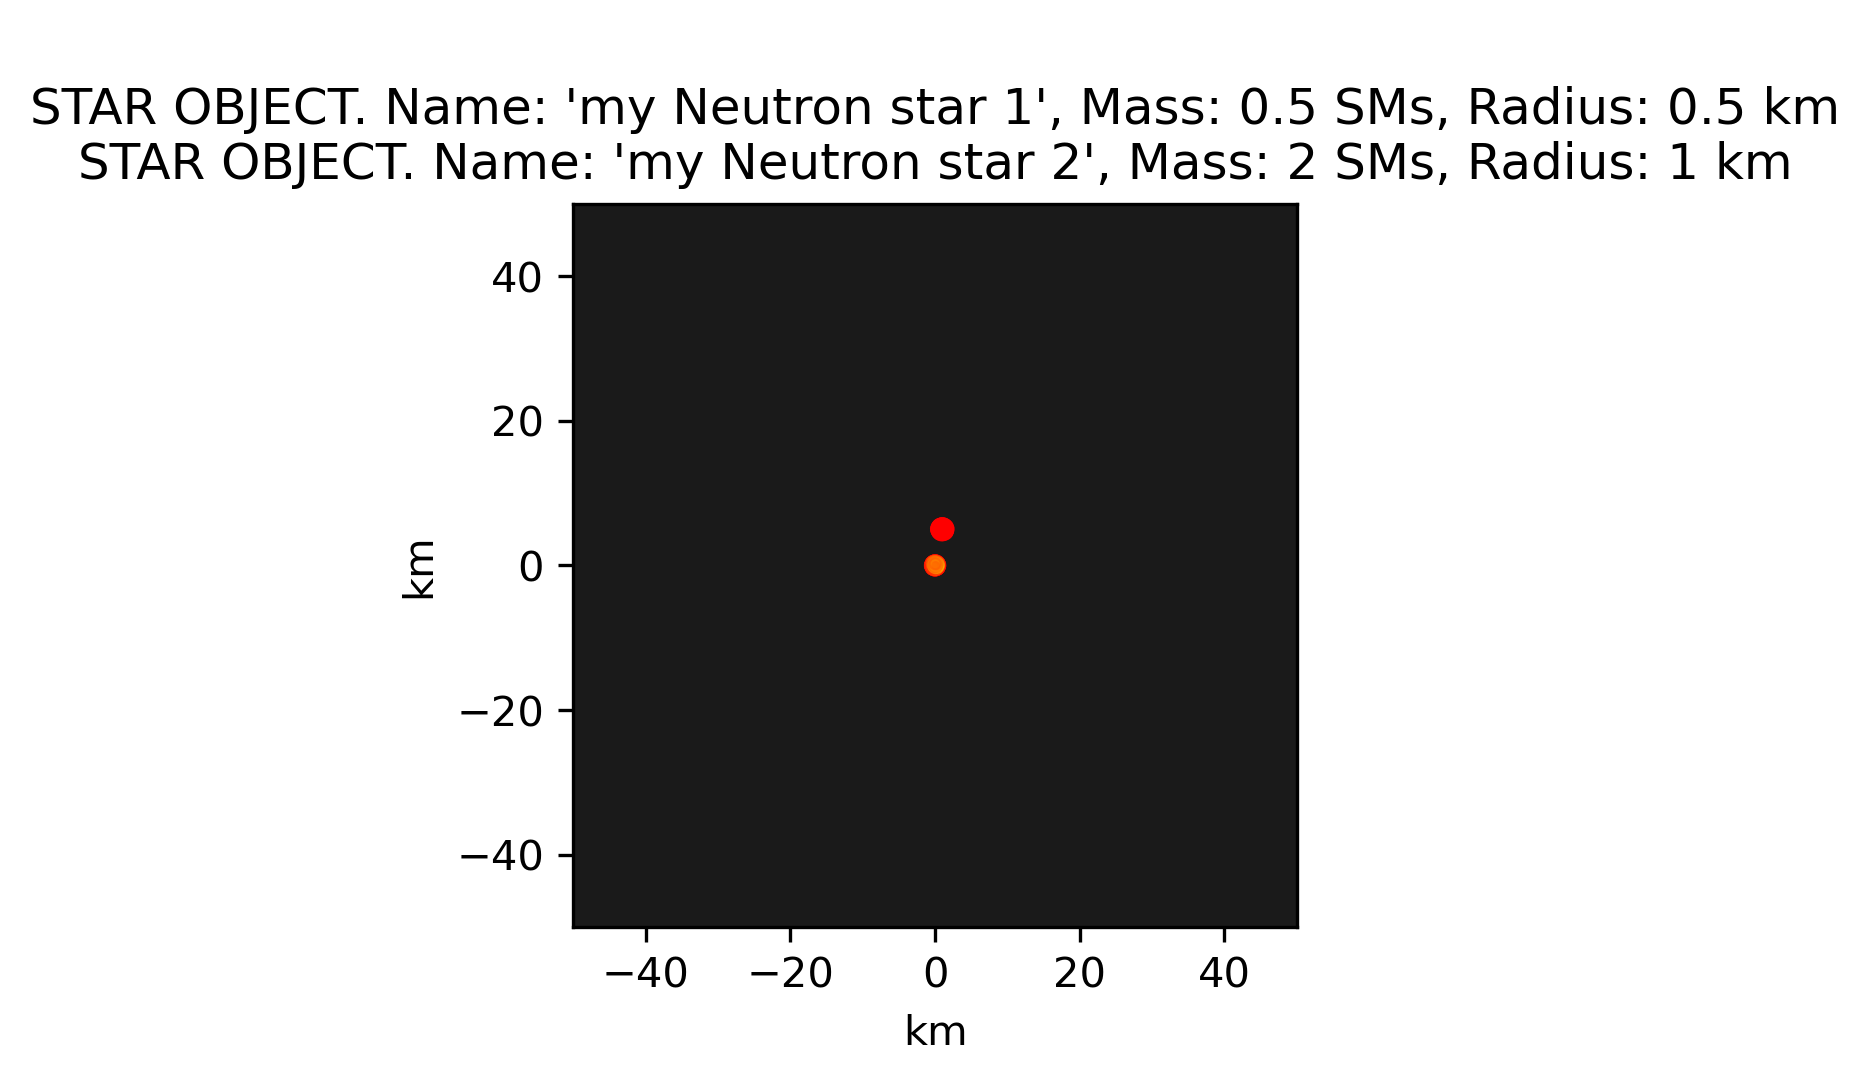

In [9]:
myNS.update_motion([pos_obj1[0], pos_obj1[1], pos_obj1[2]])
myNS2.update_motion([pos_obj2[0], pos_obj2[1], pos_obj2[2]])
both = [myNS, myNS2]
plot(both)

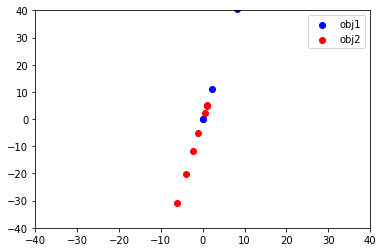

In [10]:
times = np.arange(0.01, 20, 0.1)

plot_limits = 40

vel_arr1 = np.zeros((len(times), 3))
vel_arr2 = np.zeros((len(times), 3))
pos_arr1 = np.zeros((len(times), 3))
pos_arr2 = np.zeros((len(times), 3))
pos_arr1[0] = pos_obj1
pos_arr2[0] = pos_obj2
vel_arr1[0] = v_obj1
vel_arr2[0] = v_obj2

index = 0

fig, ax = plt.subplots()
ax.set_xlim([-plot_limits,plot_limits])
ax.set_ylim([-plot_limits,plot_limits])
#AddPoint(fig, pos_arr1[0][0], pos_arr1[index][1], 'blue', 'obj1')
#AddPoint(fig, pos_arr2[0][0], pos_arr2[index][1], 'red',  'obj2')
plt.scatter(pos_arr1[0][0], pos_arr1[index][1], c='blue', label='obj1')
plt.scatter(pos_arr2[0][0], pos_arr2[index][1], c='red',  label='obj2')


#fig2 = plt.figure(figsize=(4,5), dpi = 300)
#grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
#ax2 = plt.subplot(grid[0:2,0])

for t in times:
    if index+1 >= len(times):
        break
        
    dist, unitvec = get_r(pos_arr1[index], pos_arr2[index])
    f = grav_force(mass_obj1, mass_obj2, dist, unitvec)

    vel_arr1[index+1] = vel_arr1[index] + t*f/mass_obj1
    vel_arr2[index+1] = vel_arr2[index] - t*f/mass_obj2
    pos_arr1[index+1] = (0.5*f/mass_obj1*t**2) + vel_arr1[index]*t + pos_arr1[index]
    pos_arr2[index+1] = (-0.5*f/mass_obj2*t**2) + vel_arr2[index]*t + pos_arr2[index]
    
    plt.scatter(pos_arr1[index+1][0], pos_arr1[index+1][1], c='blue')
    plt.scatter(pos_arr2[index+1][0], pos_arr2[index+1][1], c='red')
    
    #AddPoint(fig, pos_arr1[index+1][0], pos_arr1[index+1][1], c='blue', label='obj1')
    #AddPoint(fig, pos_arr2[index+1][0], pos_arr2[index+1][1], c='red',  label='obj2')
    
    index += 1

    #time.sleep(3)

plt.legend()
plt.show()

In [11]:
dist, unitvec = get_r(pos_arr1[0], pos_arr2[0])
dist, unitvec

(5.0990195135927845, array([-0.19611614, -0.98058068,  0.        ]))

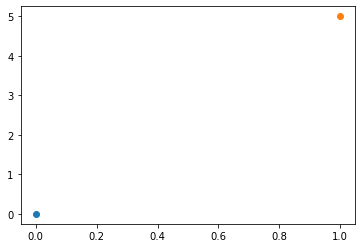

In [12]:
plt.scatter(pos_obj1[0], pos_obj1[1])
plt.scatter(pos_obj2[0], pos_obj2[1])

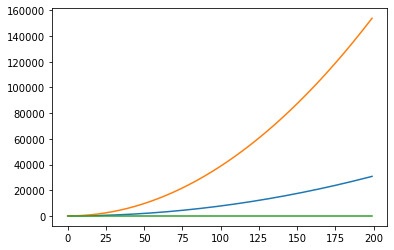

In [13]:
plt.plot(pos_arr1)

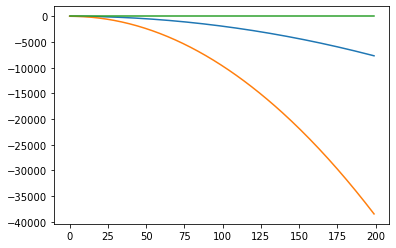

In [14]:
plt.plot(pos_arr2)

In [ ]:
for index in range(len(pos_arr1)):
    myNS.update_motion([pos_arr1[index][0], pos_arr1[index][1], pos_arr1[index][2]])
    myNS2.update_motion([pos_arr2[index][0], pos_arr2[index][1], pos_arr2[index][2]])
    both = [myNS, myNS2]
    plot(both, 10**7, 10**7)

## ODE 

In [15]:
from scipy.integrate import odeint
%matplotlib notebook
from mpl_toolkits import mplot3d

In [184]:
# time array
time = np.arange(0, 80, 0.1)

# body m1 initial conditions
m1 = mass_obj1  # mass (kg)
r10 = np.array([0, 0, 0])  # initial position (m)
v10 = np.array([0, 0, 0])  # initial velocity (m/s)

# body m2 initial conditions
m2 = mass_obj2  # mass (kg)
r20 = np.array([3000e3, 0, 0])  # initial position (m)
v20 = np.array([0, 0, 0])  # initial velocity (m/s)

# magnitude of position vector from r1 to r2
r_mag = np.linalg.norm(r20 - r10)

# initial conditions
# [X1 (0), Y1 (1), Z1 (2), X2 (3), Y2 (4), Z2 (5), VX1 (6), VY1 (7), VZ1 (8), VX2 (9), VY2 (10), VZ2 (11)]
y0 = np.concatenate((r10, r20, v10, v20))

def two_body_eqm(_y, _t, _G, _m1, _m2):
    r_mag = np.linalg.norm(_y[3:6] - _y[:3])
    c0 = _y[6:12]
    c1 = _G * _m2 * ((_y[3:6] - _y[:3]) / np.power(r_mag, 3))
    c2 = _G * _m1 * ((_y[:3] - _y[3:6]) / np.power(r_mag, 3))
    return np.concatenate((c0, c1, c2))

y = odeint(two_body_eqm, y0, time, args=(G, m1, m2))

### implement leapfrog method instead of odeint and compare

In [185]:
N = 10000
dt = 0.1

def leapfrogintegrate(pos1, pos2, vel1, vel2):
    """
    pos1 = [x,y,z] array
    pos2 = [x,y,z] array
    vel1 = [x,y,z] array
    vel2 = [x,y,z] array
    """
    # Create empty arrays 
    x1 = np.zeros(N)
    y1 = np.zeros(N)
    z1 = np.zeros(N)
    x2 = np.zeros(N)
    y2 = np.zeros(N)
    z2 = np.zeros(N)
    vx1 = np.zeros(N)
    vy1 = np.zeros(N)
    vz1 = np.zeros(N)
    vx2 = np.zeros(N)
    vy2 = np.zeros(N)
    vz2 = np.zeros(N)
    
    # initialize 

    
    for index in range(N-1):
        if index == 0:
            x1[index] = pos1[0]
            x2[index] = pos2[0]
            y1[index] = pos1[1]
            y2[index] = pos2[1]
            z1[index] = pos1[2]
            z2[index] = pos2[2]
            vx1[index] = vel1[0]
            vx2[index] = vel2[0]
            vy1[index] = vel1[1]
            vy2[index] = vel2[1]
            vz1[index] = vel1[2]
            vz2[index] = vel2[2]
        else:
            F = G*mass_obj1*mass_obj2*(x2[index-1] - x1[index-1])/(np.linalg.norm(x2[index-1] - x1[index-1]))**3
            vx1[index] = vx1[index-1]+dt*F/mass_obj1
            vy1[index] = vy1[index-1]+dt*F/mass_obj1
            vz1[index] = vz1[index-1]+dt*F/mass_obj1
            vx2[index] = vx2[index-1]+dt*F/mass_obj2
            vy2[index] = vy2[index-1]+dt*F/mass_obj2
            vz2[index] = vz2[index-1]+dt*F/mass_obj2
            x1[index] = x1[index-1]+dt*vx1[index]
            x2[index] = x2[index-1]+dt*vx2[index]
            y1[index] = y1[index-1]+dt*vy1[index]
            y2[index] = y2[index-1]+dt*vy2[index]
            z1[index] = z1[index-1]+dt*vz1[index]
            z2[index] = z2[index-1]+dt*vz2[index]
    
    return x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2    

In [186]:
x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2 = leapfrogintegrate(r10, r20, v10, v20)

<IPython.core.display.Javascript object>


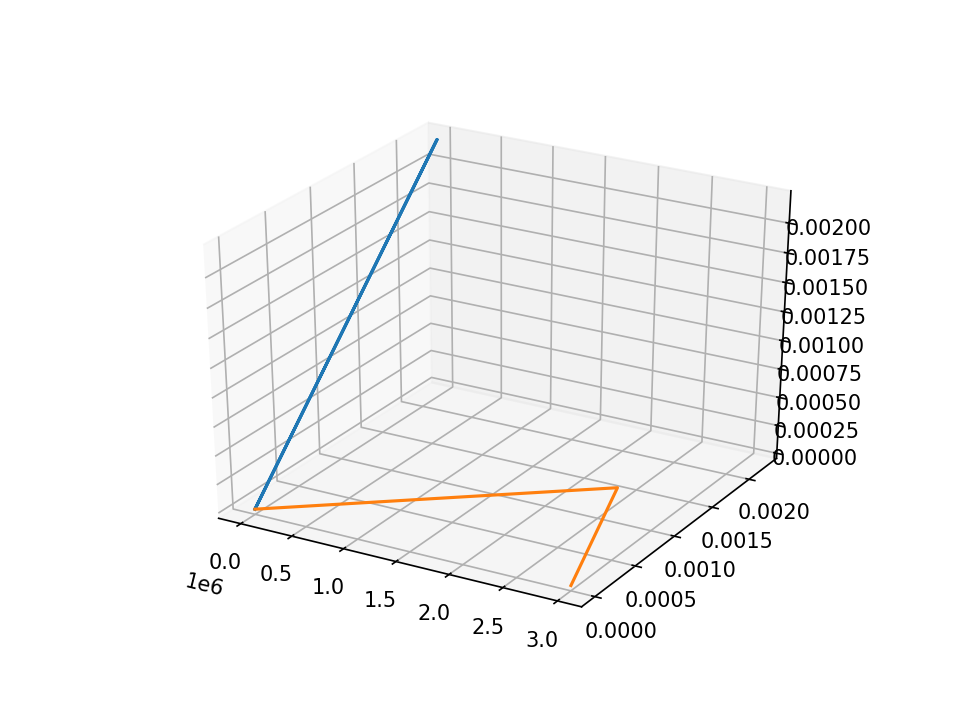

In [187]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)

### plotting 

In [188]:
state_history = []
for yk in y:
    # approximate y at time t

    # extract inertial positions of body 1 and body 2
    r1 = yk[:3]
    r2 = yk[3:6]

    # determine position of centre of mass
    rg = ((m1 * r1) + (m2 * r2)) / (m1 + m2)

    # position vector from m1 to m2
    r12 = r2 - r1

    # position vector from m1 to g
    r1g = rg - r1

    # position vector from g to m1
    rg1 = r1 - rg

    # position vector from g to m2
    rg2 = r2 - rg
    
    state_history.append(np.concatenate((yk, rg, r12, r1g, rg1, rg2), axis=None))
    
state_history = np.array(state_history)

In [189]:
y.shape

(800, 12)

In [190]:
print(state_history.shape)
state_history[:,0:11].shape

(800, 27)


(800, 11)

In [191]:
y

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.22222229e-11,  0.00000000e+00,  0.00000000e+00, ...,
        -1.11111111e-10,  0.00000000e+00,  0.00000000e+00],
       [ 8.88888896e-11,  0.00000000e+00,  0.00000000e+00, ...,
        -2.22222222e-10,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.41157556e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -8.85555556e-08,  0.00000000e+00,  0.00000000e+00],
       [ 1.41512000e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -8.86666667e-08,  0.00000000e+00,  0.00000000e+00],
       [ 1.41866889e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -8.87777778e-08,  0.00000000e+00,  0.00000000e+00]])

In [192]:
yk_full = state_history[:,0:11]
rg_full = state_history[:,11:14]
r12_full = state_history[:,14:17]
r1g_full = state_history[:,17:20]
rg1_full = state_history[:,20:23]
rg2_full = state_history[:,23:26]

In [193]:
rg2_full

array([[     0.        , 600000.        ,      0.        ],
       [     0.        , 600000.        ,      0.        ],
       [     0.        , 600000.        ,      0.        ],
       ...,
       [     0.        , 599999.99999647,      0.        ],
       [     0.        , 599999.99999646,      0.        ],
       [     0.        , 599999.99999645,      0.        ]])

In [194]:
y[0:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

<IPython.core.display.Javascript object>


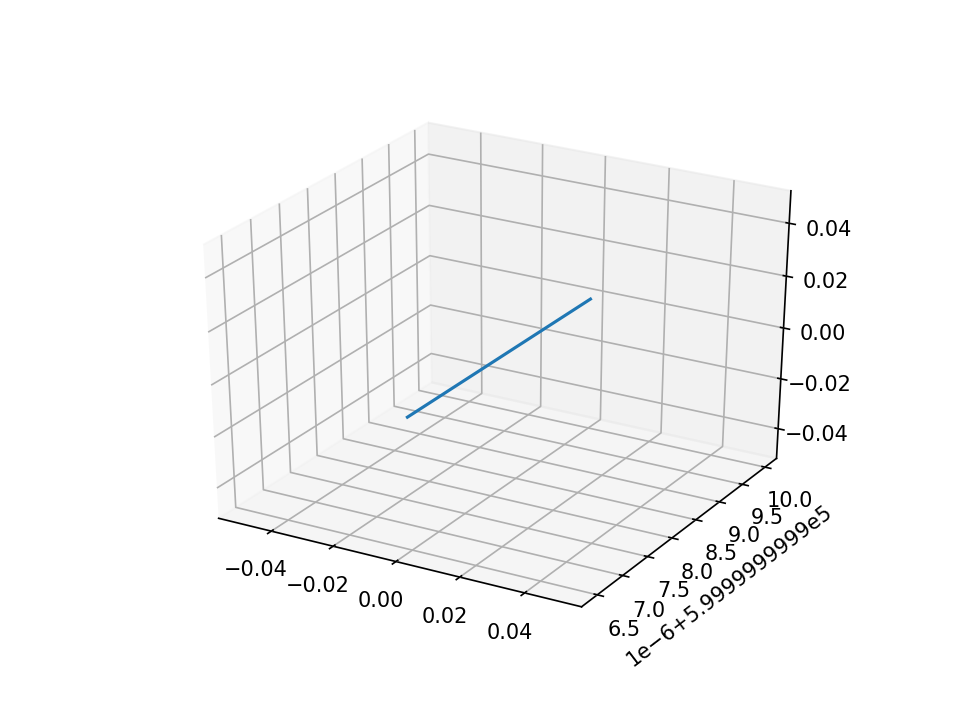

In [195]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(rg2_full[:,0], rg2_full[:,1], rg2_full[:,2])

<IPython.core.display.Javascript object>


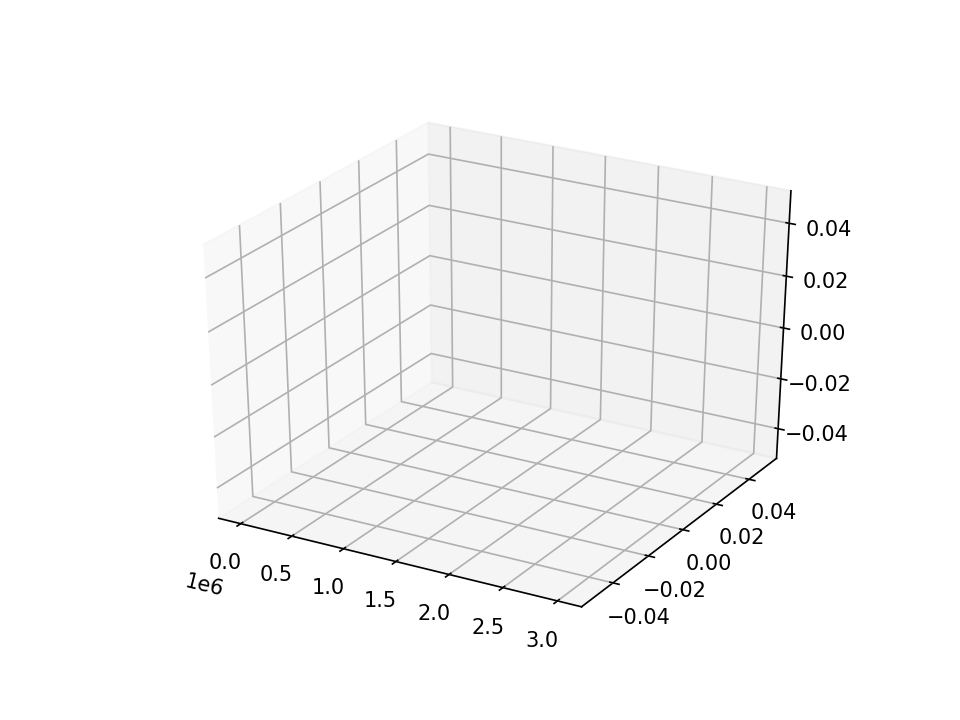

In [196]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(y[0:,0], y[0:,1], y[0:,2], c='red')
ax.plot(y[0:,3], y[0:,4], y[0:,5], c='blue')

<IPython.core.display.Javascript object>


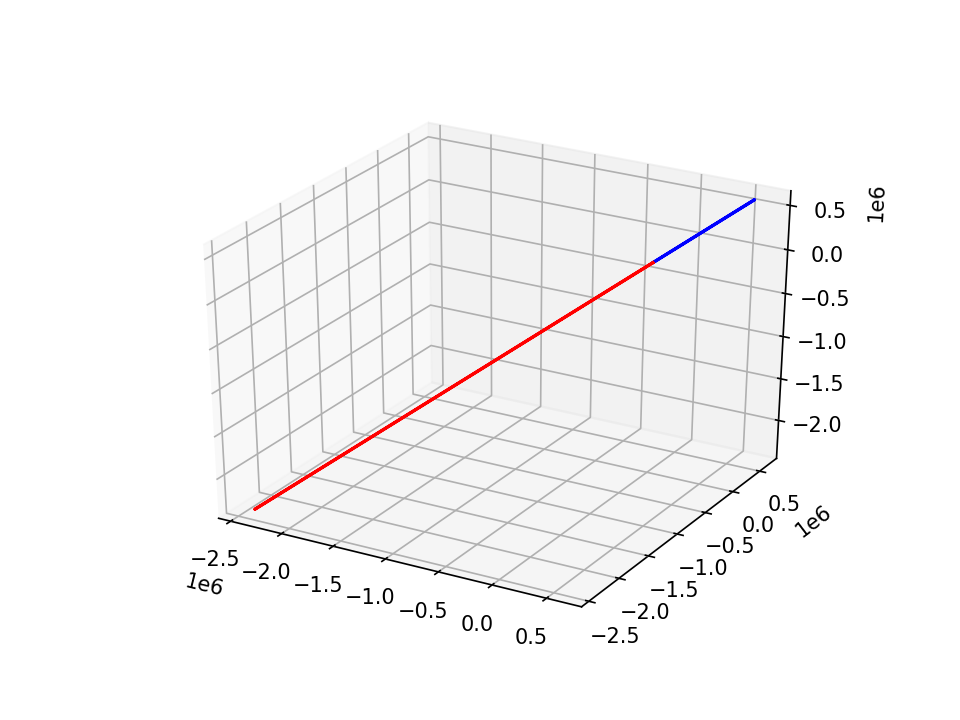

In [197]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(rg2_full[0], rg2_full[1], rg2_full[2], c='blue')
ax.plot(rg1_full[0], rg1_full[1], rg1_full[2], c='red')